In [ ]:
# !pip install numpy
# !pip install matplotlib

# !pip install qiskit
# !pip install pylatexenc
# !pip install qiskit_aer

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
import pylatexenc
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

In [ ]:
def classicalHighPassFilter(input_signal, time):
  filter_output = list()
  for t in range(len(time)):
    if t+2 < len(time):
      y = filter_coeff[0]*input_signal[t]+filter_coeff[1]*input_signal[t+1]+filter_coeff[2]*input_signal[t+2]
    else:
      y = 0
    filter_output.append(y)
  return np.array(filter_output)

In [ ]:
def filterUnitary(filter_coeff):
  filter_norm = 0

  for coeff in filter_coeff:
    filter_norm = filter_norm + coeff**2
  filter_norm = math.sqrt(filter_norm)

  U = np.array([[-filter_coeff[1]/(math.sqrt(2)*filter_norm), math.sqrt(2)*filter_coeff[0]/(filter_norm), -filter_coeff[1]/(math.sqrt(2)*filter_norm), 0],
                [math.sqrt(1/2), 0, -math.sqrt(1/2), 0],
                [filter_coeff[2]/filter_norm, filter_coeff[1]/filter_norm, filter_coeff[0]/filter_norm, 0],
                [0, 0, 0, 1]])
  print(np.linalg.det(U))
  return U

In [ ]:
def createInputState(input_signal, t):
  signal = input_signal/(np.max(np.abs(input_signal))*math.sqrt(3))
  if t+2 < len(signal):
    norm = math.sqrt(1 - signal[t+2]**2 - signal[t+1]**2 - signal[t]**2)
    ket_X = np.array([[signal[t+2]], [signal[t+1]], [signal[t]], [norm]])
  else:
    ket_X = np.array([[0], [0], [0], [1]])
  return ket_X

In [ ]:
def createInitialization(input_signal, t):
  ''' For Qiskit Realization'''
  signal = input_signal/(np.max(np.abs(input_signal))*math.sqrt(3))
  if t+2 < len(signal):
    norm = math.sqrt(1 - signal[t+2]**2 - signal[t+1]**2 - signal[t]**2)
    X = list([signal[t+2], signal[t+1], signal[t], norm])
  else:
    X = list([0, 0, 0 , 1])
  return X

In [ ]:
def filterCutOffCalculator(filter_coeff):
  print("Hi")

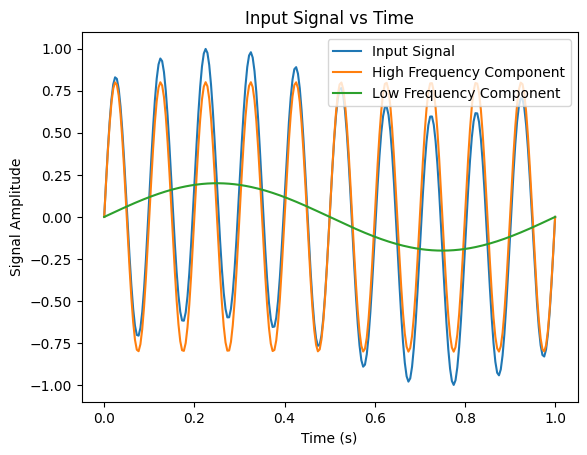

In [ ]:
#defining filter coefficients:
filter_coeff = [-1/4, 1/2, -1/4]

#define time
time = np.linspace(0,1, 250)
#define signal
high_freq = 10
low_freq = 1
dc = 0
high_freq_signal = 0.8*np.sin(2*math.pi*high_freq*time)
low_freq_signal = 0.2*np.sin(2*math.pi*low_freq*time)
input_signal =  dc + high_freq_signal + low_freq_signal

#plot input in time-domain
plt.plot(time, input_signal)
plt.plot(time, dc + high_freq_signal)
plt.plot(time, dc + low_freq_signal)
# plt.plot(time, input_signal/math.sqrt(np.max(np.abs(input_signal))))
plt.title('Input Signal vs Time')
plt.ylabel('Signal Amplitude')
plt.xlabel('Time (s)')
plt.legend(["Input Signal", "High Frequency Component", "Low Frequency Component"])
plt.show()

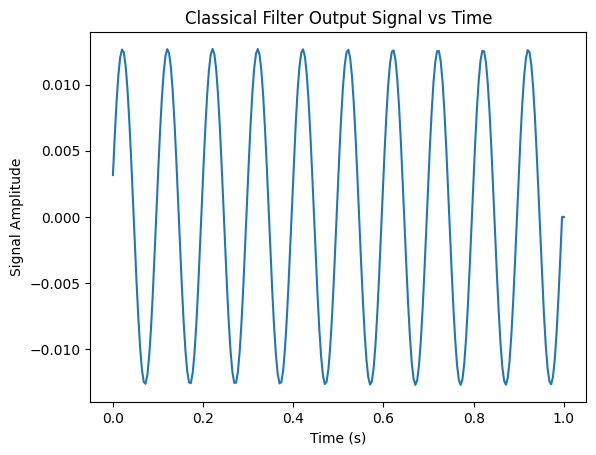

In [ ]:
# classical output
output = classicalHighPassFilter(input_signal, time)
#plot output in time-domain
plt.plot(time, output)
plt.title('Classical Filter Output Signal vs Time')
plt.ylabel('Signal Amplitude')
plt.xlabel('Time (s)')
plt.show()

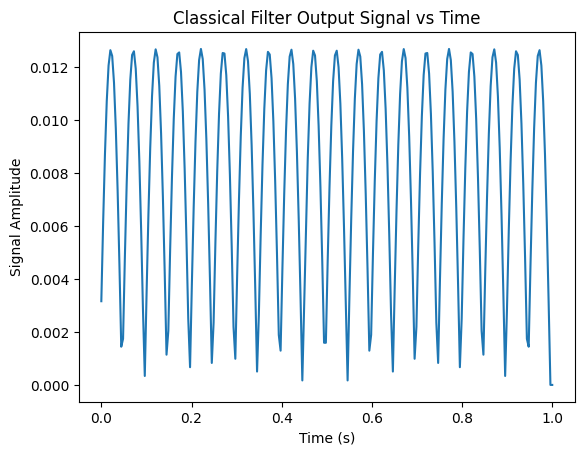

In [ ]:
# Re-checking classical output
output = classicalHighPassFilter(input_signal, time)
#plot output in time-domain
plt.plot(time, np.abs(output))
plt.title('Rectified Classical Filter Output Signal vs Time')
plt.ylabel('Signal Amplitude')
plt.xlabel('Time (s)')
plt.show()

-1.0000000000000004
[[-0.57735027 -0.57735027 -0.57735027  0.        ]
 [ 0.70710678  0.         -0.70710678  0.        ]
 [-0.40824829  0.81649658 -0.40824829  0.        ]
 [ 0.          0.          0.          1.        ]]


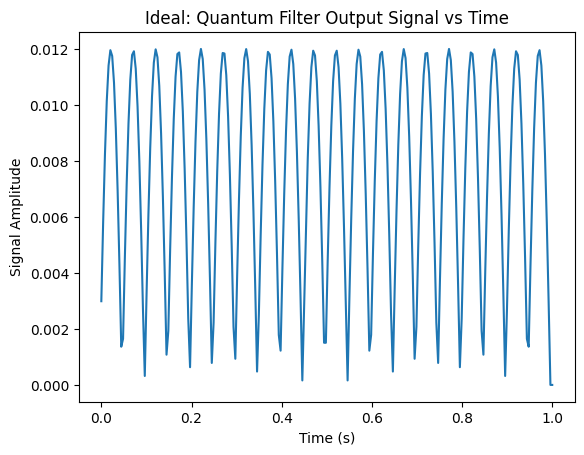

In [ ]:
y = list()
U = filterUnitary(filter_coeff)
print(U)
for t in range(len(input_signal)):

  ket_X = createInputState(input_signal, t)
  # print(ket_X)
  ket_Y = U@ket_X
  y.append(np.abs(ket_Y[2]))

# classical output
output = classicalHighPassFilter(input_signal, time)
#plot output in time-domain
plt.plot(time, y)
plt.title('Ideal: Quantum Filter Output Signal vs Time')
plt.ylabel('Signal Amplitude')
plt.xlabel('Time (s)')
plt.show()

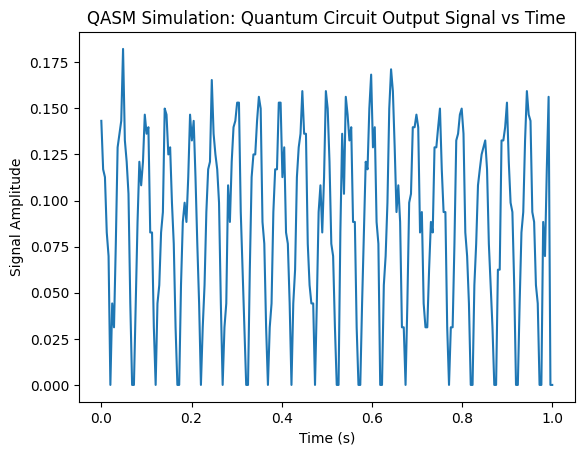

In [ ]:
qf_output = list()

for t in range(len(input_signal)):

  X = createInitialization(input_signal, t)
  # print(X)

  qc = QuantumCircuit(2)
  qc.initialize(X, [1, 0])
  qc.unitary(U, [0, 1])

  qc.measure_all()
  qasm_sim = Aer.get_backend('qasm_simulator')
  transpiled_qc = transpile(qc, qasm_sim)
  result = qasm_sim.run(transpiled_qc).result()

  # print(result.get_counts())
  try:
    qf_output.append(math.sqrt(result.get_counts()['10']/1024))
  except Exception as e:
    # print('10 is zero')
    qf_output.append(0)


plt.plot(time, qf_output)
plt.title('QASM Simulation: Quantum Circuit Output Signal vs Time')
plt.ylabel('Signal Amplitude')
plt.xlabel('Time (s)')
plt.show()